# Movie Recommender Walkthrough

This notebook accompanies the MovieLens movie recommendation demo. It explains the workflow in plain language and reuses the project's code so you can show the steps live.

## 1. The end-to-end plan

A practical machine learning project usually follows these phases:

1. Understand the problem and how success will be measured.
2. Fetch and load data sources you will rely on.
3. Clean and validate the raw files so the inputs are trustworthy.
4. Explore the data to understand behaviour, biases, and possible signals.
5. Select the features and targets the model will use.
6. Train candidate models, tune them, and compare performance.
7. Package the best model, deploy it, and keep monitoring quality.

```
[Collect Movie Ratings]
        |
[Clean & Validate Data]
        |
[Explore & Profile Data]
        |
[Select Signals & Targets]
        |
[Train & Tune Models]
        |
[Evaluate & Approve]
        |
[Package, Deploy & Monitor]
```


## 2. Notebook setup

We will first make sure the notebook can import modules from the project, and then load the Python libraries we will use.

In [16]:
# Make project imports available and pull in core libraries
import sys
from pathlib import Path

project_root = Path.cwd().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np

try:
    import matplotlib.pyplot as plt
except ImportError:
    plt = None

try:
    from IPython.display import display
except ImportError:
    display = print

pd.options.display.max_rows = 10
pd.options.display.max_columns = 10


from src.data_prep import load_movielens_100k, build_matrix_and_mappings
from src.model_knn import fit_knn
from src.recommend import recommendations_df


## 3. Peek at the raw files

Let's take a look at the raw files.


In [17]:
from pathlib import Path
raw_ratings_path = project_root / 'data' / 'raw' / 'ml-100k' / 'u.data'
raw_ratings_preview = raw_ratings_path.read_text(encoding='latin-1').splitlines()[:5]
print('u.data preview:')
for line in raw_ratings_preview:
    print(line)


"""u.data -- The full u data set, 100000 ratings by 943 users on 1682 items.
Each user has rated at least 20 movies. Users and items are
numbered consecutively from 1. The data is randomly
ordered. This is a tab separated list of
user id | item id | rating | timestamp.
The time stamps are unix seconds since 1/1/1970 UTC"""

u.data preview:
196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596


'u.data -- The full u data set, 100000 ratings by 943 users on 1682 items.\nEach user has rated at least 20 movies. Users and items are\nnumbered consecutively from 1. The data is randomly\nordered. This is a tab separated list of\nuser id | item id | rating | timestamp.\nThe time stamps are unix seconds since 1/1/1970 UTC'

In [18]:
raw_items_path = project_root / 'data' / 'raw' / 'ml-100k' / 'u.item'
raw_items_preview = raw_items_path.read_text(encoding='latin-1').splitlines()[:5]
print('u.item preview:')
for line in raw_items_preview:
    print(line)

"""
u.item -- Information about the items (movies); this is a tab separated
list of
movie id | movie title | release date | video release date |IMDb URL | unknown | Action | Adventure | Animation |Children's | Comedy | Crime | Documentary | Drama | Fantasy |
Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
Thriller | War | Western |
The last 19 fields are the genres, a 1 indicates the movie
is of that genre, a 0 indicates it is not; movies can be in several genres at once.
The movie ids are the ones used in the u.data data set.
"""

u.item preview:
1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0


"\nu.item -- Information about the items (movies); this is a tab separated\nlist of\nmovie id | movie title | release date | video release date |IMDb URL | unknown | Action | Adventure | Animation |Children's | Comedy | Crime | Documentary | Drama | Fantasy |\nFilm-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |\nThriller | War | Western |\nThe last 19 fields are the genres, a 1 indicates the movie\nis of that genre, a 0 indicates it is not; movies can be in several genres at once.\nThe movie ids are the ones used in the u.data data set.\n"

## 4. Load the dataset step by step

Next we will parse these text files with pandas so we can see exactly how the tabular data appears once loaded.

In [19]:
ratings = pd.read_csv(
    raw_ratings_path,
    sep='	',
    names=['user', 'item', 'rating', 'ts'],
    engine='python'
)
print(f'Ratings shape: {ratings.shape}')
print(ratings.head())


Ratings shape: (100000, 4)
   user  item  rating         ts
0   196   242       3  881250949
1   186   302       3  891717742
2    22   377       1  878887116
3   244    51       2  880606923
4   166   346       1  886397596


In [20]:
print('Column types:')
print(ratings.dtypes)


Column types:
user      int64
item      int64
rating    int64
ts        int64
dtype: object


In [21]:
movies = pd.read_csv(
    raw_items_path,
    sep='|',
    header=None,
    encoding='latin-1',
    engine='python'
)
movies = movies.rename(columns={0: 'item', 1: 'title'})[['item', 'title']]
print(f'Movies shape: {movies.shape}')
print(movies.head())


Movies shape: (1682, 2)
   item              title
0     1   Toy Story (1995)
1     2   GoldenEye (1995)
2     3  Four Rooms (1995)
3     4  Get Shorty (1995)
4     5     Copycat (1995)


## 5. Exploratory Data Analysis

With the data in DataFrames, we can point out quick quality checks before modelling.

In [22]:
print('Ratings min/max:', ratings['rating'].min(), ratings['rating'].max())
print('Missing values per column:', ratings.isna().sum())
duplicate_rows = ratings.duplicated(subset=['user', 'item', 'rating', 'ts']).sum()
print(f'Exact duplicate rows: {duplicate_rows}')


Ratings min/max: 1 5
Missing values per column: user      0
item      0
rating    0
ts        0
dtype: int64
Exact duplicate rows: 0


## 6. Sample exploratory analysis

These quick summaries and plots give us the intuition about sparsity, behaviour, and possible biases in the dataset.

In [23]:
user_count = ratings['user'].nunique()
item_count = ratings['item'].nunique()
rating_count = len(ratings)
median_rating = ratings['rating'].median()
avg_ratings_per_user = rating_count / user_count
avg_ratings_per_item = rating_count / item_count

summary = pd.DataFrame(
    {
        'metric': [
            'ratings',
            'users',
            'movies',
            'avg ratings per user',
            'avg ratings per movie',
            'median rating',
        ],
        'value': [
            rating_count,
            user_count,
            item_count,
            round(avg_ratings_per_user, 2),
            round(avg_ratings_per_item, 2),
            float(median_rating),
        ],
    }
)
summary


,metric,value
0,ratings,100000.00
1,users,943.00
2,movies,1682.00
3,avg ratings per user,106.04
4,avg ratings per movie,59.45
5,median rating,4.00


Ratings per score:


,count
rating,
1,6110
2,11370
3,27145
4,34174
5,21201


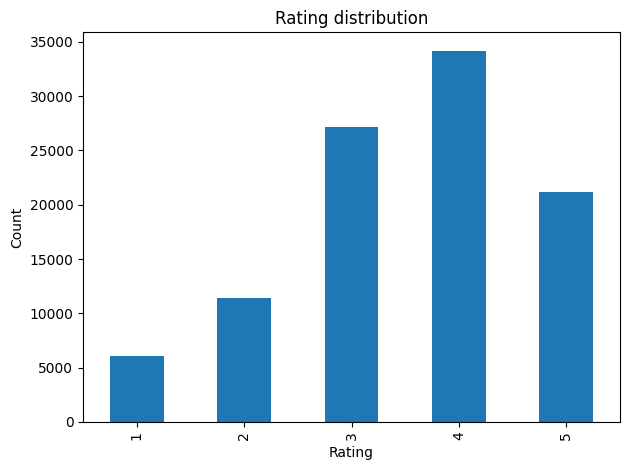

In [24]:
rating_counts = ratings['rating'].value_counts().sort_index()
print('Ratings per score:')
display(rating_counts.to_frame(name='count'))
if plt is not None:
    rating_counts.plot(kind='bar', color='#1f77b4', title='Rating distribution')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.tight_layout()
else:
    print('Install matplotlib (e.g. `pip install matplotlib`) to see this chart as a bar plot.')


Ratings per user (summary stats):
count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: rating, dtype: float64


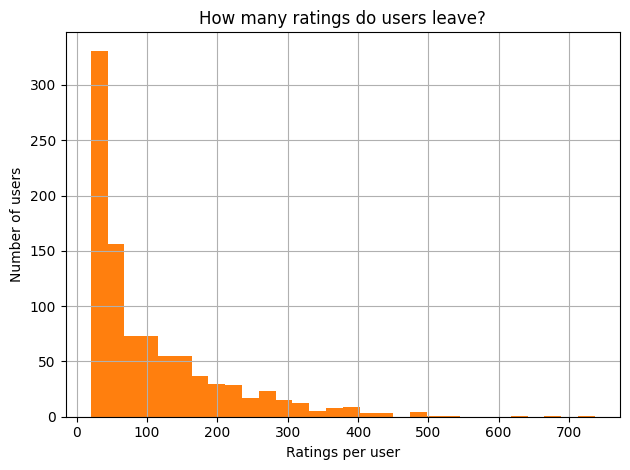

In [25]:
ratings_per_user = ratings.groupby('user')['rating'].count()
print('Ratings per user (summary stats):')
print(ratings_per_user.describe())
if plt is not None:
    ratings_per_user.hist(bins=30, color='#ff7f0e')
    plt.title('How many ratings do users leave?')
    plt.xlabel('Ratings per user')
    plt.ylabel('Number of users')
    plt.tight_layout()
else:
    print('Install matplotlib to visualise this distribution.')


Top 10 most rated movies:


,rating_count
item,
50,583
258,509
100,508
181,507
294,485
286,481
288,478
1,452
300,431


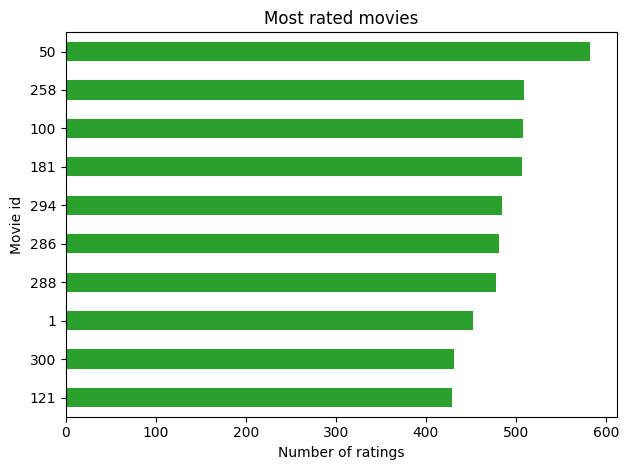

In [26]:
ratings_per_item = ratings.groupby('item')['rating'].count()
print('Top 10 most rated movies:')
top_items = ratings_per_item.sort_values(ascending=False).head(10)
display(top_items.to_frame(name='rating_count'))
if plt is not None:
    top_items.sort_values().plot(kind='barh', color='#2ca02c', title='Most rated movies')
    plt.xlabel('Number of ratings')
    plt.ylabel('Movie id')
    plt.tight_layout()
else:
    print('Install matplotlib to show the bar chart of top movies.')


C:\Users\mohan\AppData\Local\Temp\ipykernel_20976\2548890216.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  daily_counts = ratings.set_index('rating_date')['rating'].resample('M').count()


Monthly ratings volume (first 10 rows):
rating_date
1997-09-30     6704
1997-10-31    10304
1997-11-30    23980
1997-12-31    11911
1998-01-31    14095
1998-02-28    10991
1998-03-31    12656
1998-04-30     9359
Freq: ME, Name: rating, dtype: int64


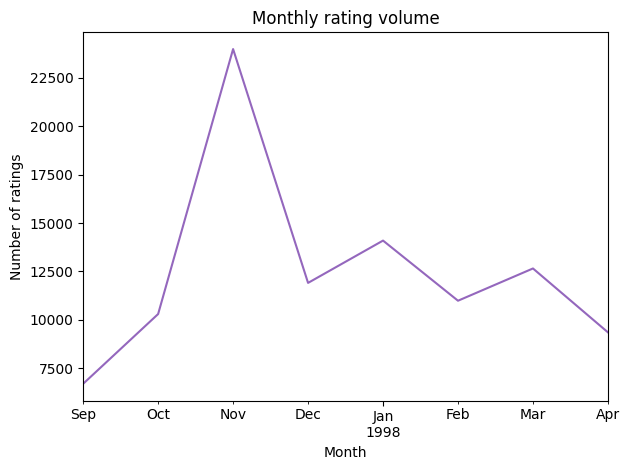

In [27]:
ratings['rating_date'] = pd.to_datetime(ratings['ts'], unit='s')
daily_counts = ratings.set_index('rating_date')['rating'].resample('M').count()
print('Monthly ratings volume (first 10 rows):')
print(daily_counts.head(10))
if plt is not None:
    daily_counts.plot(title='Monthly rating volume', color='#9467bd')
    plt.xlabel('Month')
    plt.ylabel('Number of ratings')
    plt.tight_layout()
else:
    print('Install matplotlib to see the monthly trend plot.')


## 7. Why build a user x movie matrix?

Models such as k-nearest neighbours need each user represented by a vector of movie ratings. The sparse matrix is a compact way to store that information, and the mappings tell us which row or column ties back to a real user or movie id.

In [28]:
sample_users = ratings['user'].unique()[:5]
sample_items = ratings['item'].unique()[:5]
wide_view = ratings[ratings['user'].isin(sample_users) & ratings['item'].isin(sample_items)]    .pivot_table(index='user', columns='item', values='rating')
print('User x movie view (NaN means no rating yet):')
print(wide_view)


User x movie view (NaN means no rating yet):
item  51   242  302  346  377
user                         
22    NaN  NaN  NaN  NaN  1.0
166   NaN  NaN  NaN  1.0  NaN
186   NaN  NaN  3.0  NaN  NaN
196   NaN  3.0  NaN  NaN  NaN
244   2.0  NaN  NaN  NaN  NaN


In [29]:
R, uid_to_idx, idx_to_uid, iid_to_idx, idx_to_iid = build_matrix_and_mappings(ratings)
print(f'CSR matrix shape: {R.shape}')
density = R.nnz / (R.shape[0] * R.shape[1])
print(f'Matrix density: {density:.4%}')


CSR matrix shape: (943, 1682)
Matrix density: 6.3047%


Top-left of the sparse matrix as a dense table:
     1    2    3    4    5
1  5.0  3.0  4.0  3.0  3.0
2  4.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0
5  4.0  3.0  0.0  0.0  0.0
Sample of user id -> matrix row mapping:
   user_id  matrix_row
0        1           0
1        2           1
2        3           2
3        4           3
4        5           4
Sample of movie id -> matrix column mapping:
   movie_id  matrix_col
0         1           0
1         2           1
2         3           2
3         4           3
4         5           4


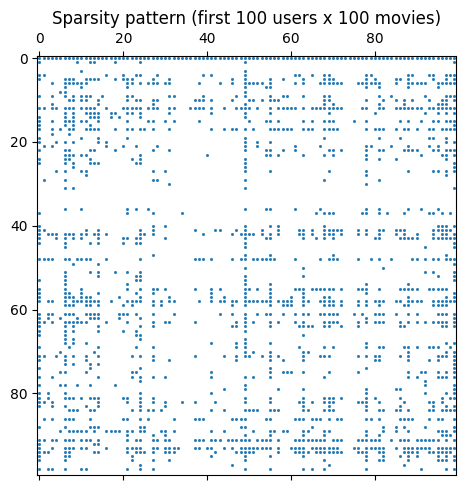

In [30]:
import numpy as np
matrix_snapshot = pd.DataFrame(
    R[:5, :5].toarray(),
    index=[idx_to_uid[i] for i in range(5)],
    columns=[idx_to_iid[j] for j in range(5)]
)
print('Top-left of the sparse matrix as a dense table:')
print(matrix_snapshot)

uid_lookup_sample = pd.DataFrame(list(uid_to_idx.items())[:5], columns=['user_id', 'matrix_row'])
iid_lookup_sample = pd.DataFrame(list(iid_to_idx.items())[:5], columns=['movie_id', 'matrix_col'])
print('Sample of user id -> matrix row mapping:')
print(uid_lookup_sample)
print('Sample of movie id -> matrix column mapping:')
print(iid_lookup_sample)

if plt is not None:
    plt.figure(figsize=(5, 5))
    plt.spy(R[:100, :100], markersize=1)
    plt.title('Sparsity pattern (first 100 users x 100 movies)')
    plt.tight_layout()
else:
    print('Install matplotlib to visualise the sparsity pattern.')


## 8. Train the user-based kNN model

The helper in `src/model_knn.py` wraps scikit-learn's `NearestNeighbors`. Cosine distance works well on sparse rating vectors because it measures angle similarity instead of raw magnitude.

In [31]:
knn_model = fit_knn(R)
knn_model


,n_neighbors,5
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


## 9. Generate recommendations interactively

To reuse the ranking logic from `src/recommend.py`, we create a lightweight artifacts object with the inputs that module expects.

In [32]:
from dataclasses import dataclass
from scipy.sparse import csr_matrix

@dataclass
class NotebookArtifacts:
    R: csr_matrix
    knn: object
    uid_to_idx: dict
    idx_to_uid: dict
    iid_to_idx: dict
    idx_to_iid: dict
    item_meta: dict

item_meta = dict(zip(movies['item'].astype(int), movies['title'].astype(str)))
artifacts = NotebookArtifacts(
    R=R,
    knn=knn_model,
    uid_to_idx=uid_to_idx,
    idx_to_uid=idx_to_uid,
    iid_to_idx=iid_to_idx,
    idx_to_iid=idx_to_iid,
    item_meta=item_meta,
)

example_user = 42
print(f'Example user: {example_user}')
display(recommendations_df(
    artifacts,
    raw_user_id=example_user,
    k_neighbors=20,
    topn=5,
    min_neighbor_rating=4.0,
))


Example user: 42


,item_id,title,score
0,22,Braveheart (1995),42.277728
1,117,"Rock, The (1996)",35.752094
2,191,Amadeus (1984),33.044852
3,133,Gone with the Wind (1939),32.951557
4,258,Contact (1997),32.331456


In [ ]:
"""
ratings =
   user  item  rating
0     5    10       4
1     5    42       5
2     8    10       3
3    11    99       2


When you set example_user = 42 and call recommendations_df, the helper function loads those pieces and passes them into recommend_for_user, 
which does the actual work:

It looks up user 42’s row index via uid_to_idx. Suppose uid_to_idx[42] == 123; 
row 123 of R is that user’s rating vector.

The kNN model finds the closest k_neighbors=20 other users in the matrix space. 
Say the three strongest neighbors returned are user rows [87, 998] wi301, th cosine similarities [0.92, 0.83, 0.78] 
(remember, the code converts distances returned by scikit-learn into similarities with 1 - distance).

For each neighbor, the code pulls that neighbor’s rating row, selects the movies they rated at 
least min_neighbor_rating=4.0, and skips any movie user 42 already rated (seen_items). In a toy example:

Neighbor 87 (sim 0.92) loved movies 12 (rating 5.0) and 58 (rating 4.5).
Neighbor 301 (sim 0.83) loved movies 12 (4.0) and 71 (5.0).
Neighbor 998 (sim 0.78) loved movies 33 (4.5) and 58 (4.0).
Scores are aggregated as similarity × neighbor_rating, so the contributions would be:

Movie 12 → 0.92*5.0 + 0.83*4.0 = 6.8
Movie 58 → 0.92*4.5 + 0.78*4.0 = 7.0
Movie 71 → 0.83*5.0 = 4.15
Movie 33 → 0.78*4.5 = 3.51
After sorting by score and taking topn=5, the function converts the column indices back to the original MovieLens ids using idx_to_iid and decorates them with titles from item_meta. The returned DataFrame therefore shows something like:
"""

### A quick precision example

Holding out a few high-rated movies and checking whether they appear in the recommendation list gives a simple accuracy story for non-ML audiences.

In [33]:
def quick_precision_demo(user_id: int, holdout_size: int = 5, topn: int = 5):
    user_history = ratings[ratings['user'] == user_id].sort_values('ts')
    if len(user_history) <= holdout_size:
        raise ValueError('User does not have enough ratings for this demo.')

    holdout = user_history.tail(holdout_size)
    train_part = ratings.drop(holdout.index)
    R_train, uid2idx_train, idx2uid_train, iid2idx_train, idx2iid_train = build_matrix_and_mappings(train_part)
    model_train = fit_knn(R_train)

    artifacts_train = NotebookArtifacts(
        R=R_train,
        knn=model_train,
        uid_to_idx=uid2idx_train,
        idx_to_uid=idx2uid_train,
        iid_to_idx=iid2idx_train,
        idx_to_iid=idx2iid_train,
        item_meta=item_meta,
    )

    recs = recommendations_df(
        artifacts_train,
        raw_user_id=user_id,
        k_neighbors=20,
        topn=topn,
        min_neighbor_rating=4.0,
    )

    relevant = set(holdout.loc[holdout['rating'] >= 4, 'item'])
    hits = recs['item_id'].isin(relevant).sum()
    precision = hits / len(recs) if len(recs) else 0.0
    return recs, holdout[['item', 'rating']], precision, relevant

candidate_users = ratings['user'].value_counts()
top_user = candidate_users[candidate_users > 10].idxmax()

recs, holdout, precision, relevant = quick_precision_demo(top_user)
print(f'Demo user: {top_user}')
print(f'Relevant (held-out) liked movie ids: {sorted(relevant)}')
print(f'Precision@5: {precision:.2f}')

display(recs)
display(holdout)


Demo user: 405
Relevant (held-out) liked movie ids: []
Precision@5: 0.00


,item_id,title,score
0,100,Fargo (1996),34.412918
1,151,Willy Wonka and the Chocolate Factory (1971),31.914917
2,153,"Fish Called Wanda, A (1988)",31.451935
3,144,Die Hard (1988),31.430795
4,483,Casablanca (1942),30.558684


,item,rating
14316,1434,1
16612,361,2
16502,1316,1
14986,1176,3
76286,1591,1


## 10. What if we swap the model?

- **Matrix factorisation (e.g. SVD, ALS):** saves user and item embeddings instead of neighbour graphs, often boosts accuracy on sparse explicit feedback, but explanations become more abstract.
- **Item-based kNN:** recommends "movies similar to what you already loved"; great for power users but can shrink catalogue diversity.
- **Neural or hybrid approaches:** combine collaborative filtering with metadata (genres, descriptions, embeddings) to solve cold-start situations.

The evaluation recipe above (hold out feedback, compute precision/recall) still applies, so stakeholders can compare behaviour before adopting a new model.